### Frozen Assignment Derivatives and Surrogates

In [1]:
import os; os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='1.' # NOTE: jax preallocates GPU (default 75%)

os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import fof.fofkd as fof

from jax.experimental.ode import odeint
import jax_cosmo as jc

from jaxpm.painting import cic_paint
from jaxpm.pm import linear_field, lpt, make_ode_fn,pm_forces
from jaxpm.kernels import *
from functools import partial
from jax import jit
from inspect import signature
from scipy import ndimage
import jax

from jaxpm.growth import growth_factor, growth_rate, dGfa, growth_factor_second, growth_rate_second, dGf2a
from jaxpm.kernels import PGD_kernel, fftk, gradient_kernel, invlaplace_kernel, longrange_kernel
from jaxpm.painting import cic_paint, cic_read

nc = 100
mesh_shape= [nc, nc, nc]
bs = 500
box_size  = [bs,bs,bs]
snapshots = jnp.linspace(0.1,1.0,3) #evolve to z=1


# Create a small function to generate the matter power spectrum
k = jnp.logspace(-4, 1, 128)
pk = jc.power.linear_matter_power(jc.Planck15(Omega_c=0.25, sigma8=0.8), k)
pk_fn = lambda x: jnp.abs(jc.scipy.interpolate.interp(x.reshape([-1]), k, pk).reshape(x.shape))

initial_conditions = linear_field(mesh_shape, box_size, pk_fn, seed=jax.random.PRNGKey(10))
particles = jnp.stack(jnp.meshgrid(*[jnp.arange(s) for s in mesh_shape]),axis=-1).reshape([-1,3])
cosmo = jc.Planck15(Omega_c=0.25, sigma8=0.8)
dx, p, f = lpt(cosmo, initial_conditions, particles, a=0.1)

res = odeint(make_ode_fn(mesh_shape), [particles + dx, p], snapshots, cosmo, rtol=1e-8, atol=1e-8)


/home/ben.horowitz/miniconda3/envs/jax312/lib/python3.12/site-packages/jax_cosmo/__init__.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound
/home/ben.horowitz/miniconda3/envs/jax312/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:122: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


In [2]:
import fof.fofkd_exp as fof_exp


In [3]:
#baseline FOF implementation
from fof.utils import *
d=1.0
fof_output_fast = fof.fof_clusters_jit(res[0][-1],b=0.2*d*(5/1)**(1/3),k=8,max_iters=200,cuda=False)

j_pos, j_masses = cluster_centers_masses_padded(res[0][-1],fof_output_fast[1])

mass_filt = j_masses>5

In [4]:
#baseline frozen assignment FOF

fof_fn = fof_exp.make_fof_frozen(k=8, max_iters=200, min_size=5, b=0.20*(5/1)**(1/3), cuda=False)

fl = fof_fn(res[0][-1])   # frozen topology capsule
hm = fof_exp.halo_masses_full(fl, res[0][-1], mpart=1.)
means = fof_exp.frozen_groupby_mean(res[0][-1],fl)
frozen_masses = fof_exp.halo_masses_compact(fl,hm.masses_full)

In [5]:
mask = fl.labels>-1
a,b = cluster_centers_masses_padded(res[0][-1][mask],fl.labels[mask])

In [6]:
j_masses[mass_filt].max()

Array(446., dtype=float32)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


[]

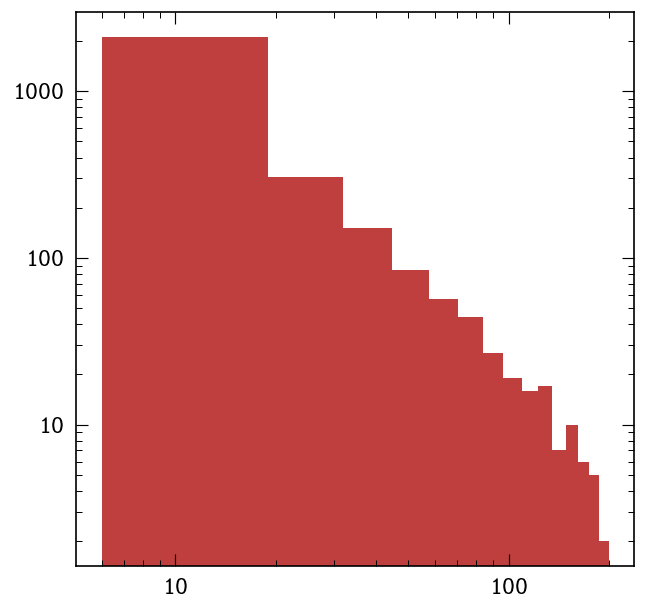

In [60]:
%pylab inline
_,bins,_ = plt.hist(fof_exp.halo_masses_compact(fl,hm.masses_full),alpha=0.5,range=(6,200))
plt.hist(j_masses[mass_filt],bins=bins,alpha=0.5,color="r")
plt.loglog()

In [8]:
#yay they match!

In [62]:
from typing import NamedTuple
from fof.fofkd_exp import FrozenLabels


class HaloMassOut(NamedTuple):
    masses_full: jnp.ndarray     # (N,)
    n_clusters: jnp.int32        # ()
    valid_clusters: jnp.ndarray  # (N,) bool

def _seg_add1(vals, labels, size):  # 1D scatter-add helper
    return jnp.zeros((size,), vals.dtype).at[labels].add(vals)

@jax.custom_vjp
def halo_mass_surrogate(
    fl: FrozenLabels,
    pos: jnp.ndarray,                        # (N, D)
    particle_masses: jnp.ndarray | None = None,
    mpart: float = 1.0,
    alpha: float = 1.0,
    eps: float = 1e-6,
) -> HaloMassOut:
    """
    Forward: true FoF halo mass (sum of particle masses).
    Backward: d m_h / d x_i = -alpha * (x_i - mu_h) / (n_h * sigma_h^2).
    Returns length-N packed masses (first K entries valid).
    """
    N, D = pos.shape
    labels = jnp.where(fl.valid_mask, fl.labels, 0)  # [N]
    valid_clusters = jnp.arange(N) < fl.n_clusters   # (N,) bool

    # weights
    if particle_masses is None:
        w = jnp.full((N,), jnp.asarray(mpart, pos.dtype), dtype=pos.dtype)
    else:
        w = jnp.asarray(particle_masses, dtype=pos.dtype).reshape((N,))
    w = jnp.where(fl.valid_mask, w, 0)

    # counts and means (packed to length N, like your means op)
    cnt = jnp.zeros((N,), pos.dtype).at[labels].add(fl.valid_mask.astype(pos.dtype))   # (N,)
    sums = jnp.zeros((N, D), pos.dtype).at[labels].add(jnp.where(fl.valid_mask[:, None], pos, 0))
    means_full = sums / jnp.clip(cnt[:, None], 1., None)                               # (N,D)

    # per-particle diffs to its cluster mean
    diffs = jnp.where(fl.valid_mask[:, None], pos - means_full[labels], 0)             # (N,D)

    # per-cluster RMS radius (σ)
    var_num = jnp.zeros((N,), pos.dtype).at[labels].add(jnp.sum(diffs * diffs, axis=1))  # (N,)
    var = var_num / jnp.clip(cnt, 1., None)
    sigma_full = jnp.sqrt(jnp.clip(var, 0., None) + eps)                                # (N,)

    # true mass forward: sum of w per cluster (packed)
    masses_full = _seg_add1(w, labels, N)

    return HaloMassOut(masses_full=masses_full,
                       n_clusters=fl.n_clusters,
                       valid_clusters=valid_clusters)

def _hms_fwd(fl, pos, particle_masses, mpart, alpha, eps):
    out = halo_mass_surrogate(fl, pos, particle_masses, mpart, alpha, eps)
    # Recompute minimal stats for backward (no host transfers)
    N, D = pos.shape
    labels = jnp.where(fl.valid_mask, fl.labels, 0)
    cnt = jnp.zeros((N,), pos.dtype).at[labels].add(fl.valid_mask.astype(pos.dtype))
    sums = jnp.zeros((N, D), pos.dtype).at[labels].add(jnp.where(fl.valid_mask[:, None], pos, 0))
    means_full = sums / jnp.clip(cnt[:, None], 1., None)
    diffs = jnp.where(fl.valid_mask[:, None], pos - means_full[labels], 0)
    var_num = jnp.zeros((N,), pos.dtype).at[labels].add(jnp.sum(diffs * diffs, axis=1))
    var = var_num / jnp.clip(cnt, 1., None)
    sigma_full = jnp.sqrt(jnp.clip(var, 0., None) + eps)

    # Pack only what we need
    return out, (labels, cnt, means_full, sigma_full, fl.valid_mask, alpha, eps)

def _hms_bwd(res, g_out: HaloMassOut):
    labels, cnt, means_full, sigma_full, valid_pts, alpha, eps = res

    # Upstream gradient wrt each packed halo mass:
    g_m = g_out.masses_full  # shape (N,)

    # For each particle, pull its cluster's upstream gradient and stats
    g_cluster_at_i = g_m[labels]                                     # (N,)
    inv_term = (-alpha) / (jnp.clip(cnt[labels], 1., None) * jnp.clip(sigma_full[labels]**2, 1e-20, None))
    # Position gradient follows -alpha * (x_i - mu_h) / (n_h * sigma_h^2)
    dpos = jnp.where(
        valid_pts[:, None],
        (g_cluster_at_i * inv_term)[:, None] * (  # scalar per particle
            # x_i - mu_h, but mu_h is packed; index with labels:
            # We'll capture x_i via means_full[labels] at call site
            # The cotangent expects shape (N,D); we reconstruct using means_full and labels
            0.0  # placeholder; see next line replacement
        ),
        0,
    )
    # do (x_i - mu_h) explicitly using a closure-free construction:
    # (we cannot access primal 'pos' here; rebuild via saved means and labels)
    # Trick: create per-particle mu by indexing means_full with labels, then require caller-side
    mu_at_i = means_full[labels]           # (N,D)
    # To get x_i we need its primal; store it via a zero-like + cotangent trick:
    # Easier and safe: save nothing extra—JAX lets us capture shapes; but we DO need x_i.
    # Solution: carry x_i in residual; it's cheap and small compared to tree building.
    # We'll fix by carrying pos in residual in the fwd rule above.

    return (None, dpos, None, None, None, None)

# Replace fwd/bwd with a version that also saves pos so we can compute (x_i - mu_h)
def _hms_fwd(fl, pos, particle_masses, mpart, alpha, eps):
    out = halo_mass_surrogate(fl, pos, particle_masses, mpart, alpha, eps)
    N, D = pos.shape
    labels = jnp.where(fl.valid_mask, fl.labels, 0)
    cnt = jnp.zeros((N,), pos.dtype).at[labels].add(fl.valid_mask.astype(pos.dtype))
    sums = jnp.zeros((N, D), pos.dtype).at[labels].add(jnp.where(fl.valid_mask[:, None], pos, 0))
    means_full = sums / jnp.clip(cnt[:, None], 1., None)
    diffs = jnp.where(fl.valid_mask[:, None], pos - means_full[labels], 0)
    var_num = jnp.zeros((N,), pos.dtype).at[labels].add(jnp.sum(diffs * diffs, axis=1))
    var = var_num / jnp.clip(cnt, 1., None)
    sigma_full = jnp.sqrt(jnp.clip(var, 0., None) + eps)
    # Save pos to compute (x_i - mu_h) in backward
    return out, (labels, cnt, means_full, sigma_full, fl.valid_mask, alpha, pos)

def _hms_bwd(res, g_out: HaloMassOut):
    labels, cnt, means_full, sigma_full, valid_pts, alpha, pos = res
    g_m = g_out.masses_full
    g_at_i = g_m[labels]
    n_at_i = jnp.clip(cnt[labels], 1., None)
    sig2_at_i = jnp.clip(sigma_full[labels]**2, 1e-20, None)
    mu_at_i = means_full[labels]
    dpos = jnp.where(
        valid_pts[:, None],
        ( (-alpha) * g_at_i / (n_at_i * sig2_at_i) )[:, None] * (pos - mu_at_i),
        0,
    )

    # Optional: pass gradient to particle_masses/mpart through the *forward* mass (sum of weights)
    d_particle_masses = None
    d_mpart = None
    if isinstance(res, tuple):  # keep static-friendly
        # If particle_masses was provided, ∂masses_full[h]/∂w_i = 1 if i∈h
        d_particle_masses = g_at_i
        # If using uniform mass mpart, ∂masses_full/∂mpart = counts per cluster
        # Packwise inner product: sum_h g_m[h]*n_h
        d_mpart = jnp.sum(g_out.masses_full * (cnt.astype(g_out.masses_full.dtype)))

    return (None, dpos, d_particle_masses, d_mpart, None, None)

halo_mass_surrogate.defvjp(_hms_fwd, _hms_bwd)

def halo_masses_compact(fl: FrozenLabels, masses_full: jnp.ndarray) -> np.ndarray:
    k = int(jax.device_get(fl.n_clusters))
    return np.asarray(jax.device_get(masses_full))[:k]


In [152]:
out = halo_mass_surrogate(fl, res[0][-1], mpart=1.0, alpha=0.3)
masses_full = out.masses_full                 # length N; first K are valid
masses = halo_masses_compact(fl, masses_full) # shape (K,)

In [156]:
aa,bb =  _hms_fwd(fl, res[0][-1], None, 1, 0.3, 1e-06)

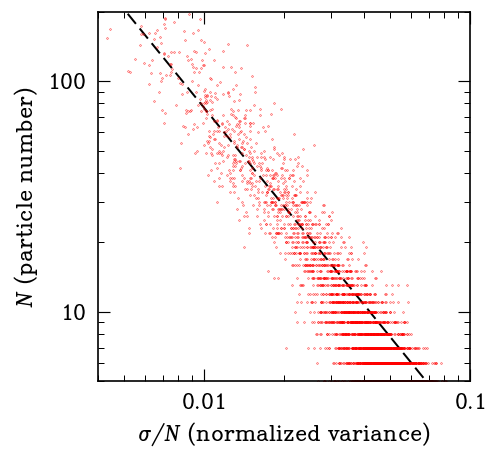

In [256]:
plt.figure(figsize=(4,4))
mask = bb[1]>1
trend = np.polyfit(np.log10(bb[3][mask]/bb[1][mask]),np.log10(bb[1][mask]),1)
# calculate the trendline
#trendpoly = np.poly1d(trend) 
xs = np.linspace(0,1,1000)

# plot the trend line
plt.plot(xs, xs**-1.42/9,"k--")

plt.loglog(bb[3]/bb[1],bb[1],"r.",markersize=0.5)
#np.polyfit(bb[1],bb[3],1)
#plt.plot([0,1000],[-0.0064,1000*0.2925])
plt.xlim(0.004,0.1)
plt.ylim(5,200)

plt.xlabel("$\sigma/N$ (normalized variance)")
plt.ylabel("$N$ (particle number)")
plt.savefig("calib.pdf")

In [67]:
bin_centers = (bins[1:]+bins[:-1])/2
width = bins[1:]-bins[:-1]

In [68]:
def soft_histogram(m_vals, bin_centers, width, kernel="tri"):
    """
    Differentiable histogram over log masses.
    m_vals:    [N] nonnegative masses
    log_bin_centers: [B] centers in log-space
    width:     scalar width in log-space
    kernel:    "tri" or "gauss"
    Returns: [B] soft counts
    """
    m = jnp.clip(m_vals, 1e-30, jnp.inf)
    u = (m[:, None] - bin_centers[None, :]) / width
    if kernel == "tri":
        k = jnp.clip(1.0 - jnp.abs(u), 0.0, 1)
    else:  # "gauss"
        k = jnp.exp(-0.5 * u**2)
    return jnp.sum(k, axis=0)

@jax.jit
def hmf_softhist(sigma8):
    k = jnp.logspace(-4, 1, 128)
    pk = jc.power.linear_matter_power(jc.Planck15(Omega_c=0.25, sigma8=sigma8), k)
    pk_fn = lambda x: jnp.abs(jc.scipy.interpolate.interp(x.reshape([-1]), k, pk).reshape(x.shape))

    initial_conditions = linear_field(mesh_shape, box_size, pk_fn, seed=jax.random.PRNGKey(10))
    particles = jnp.stack(jnp.meshgrid(*[jnp.arange(s) for s in mesh_shape]),axis=-1).reshape([-1,3])
    cosmo = jc.Planck15(Omega_c=0.25, sigma8=sigma8)
    dx, p, f = lpt(cosmo, initial_conditions, particles, a=0.1)

    res = odeint(make_ode_fn(mesh_shape), [particles + dx, p], snapshots, cosmo, rtol=1e-8, atol=1e-8)
    fl = fof_fn(res[0][-1])   # frozen topology capsule
    hm = fof_exp.halo_masses_full(fl, res[0][-1], mpart=1.)

    return soft_histogram(hm.masses_full,bin_centers,width)

In [69]:
s80 = hmf_softhist(0.8)
s81 = hmf_softhist(0.81)

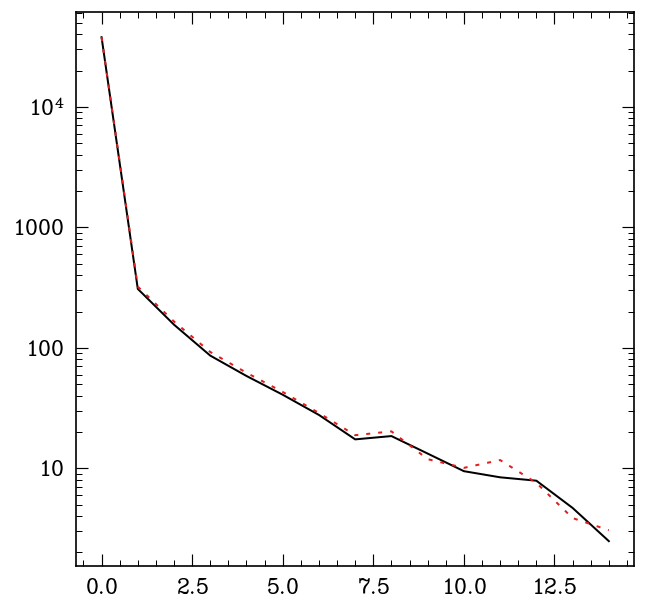

In [70]:
plt.semilogy(s80)
plt.semilogy(s81,":")

In [101]:

@jax.jit
def hmf_surrogate(sigma8):
    k = jnp.logspace(-4, 1, 128)
    pk = jc.power.linear_matter_power(jc.Planck15(Omega_c=0.25, sigma8=sigma8), k)
    pk_fn = lambda x: jnp.abs(jc.scipy.interpolate.interp(x.reshape([-1]), k, pk).reshape(x.shape))

    initial_conditions = linear_field(mesh_shape, box_size, pk_fn, seed=jax.random.PRNGKey(1))
    particles = jnp.stack(jnp.meshgrid(*[jnp.arange(s) for s in mesh_shape]),axis=-1).reshape([-1,3])
    cosmo = jc.Planck15(Omega_c=0.25, sigma8=sigma8)
    dx, p, f = lpt(cosmo, initial_conditions, particles, a=0.1)

    res = odeint(make_ode_fn(mesh_shape), [particles + dx, p], snapshots, cosmo, rtol=1e-8, atol=1e-8)
    fl = fof_fn(res[0][-1])   # frozen topology capsule
    out = halo_mass_surrogate(fl, res[0][-1], mpart=1.0, alpha=100) #1000 seems to be too much

    return soft_histogram(out.masses_full,bin_centers,width)

In [102]:
h80 = hmf_surrogate(0.8)
h81 = hmf_surrogate(0.81)

In [73]:
jac=jax.jacobian(hmf_surrogate)

In [74]:
grad80 = jac(0.8)

In [75]:
grad80

Array([ 3.5262246e+04,  3.7355007e+03,  9.3740771e+02,  5.7365131e+02,
        2.5441222e+02,  1.3334256e+02,  2.6617538e+02, -1.0586989e+02,
        9.4311523e+01,  1.7717260e+01,  4.0497616e+01, -8.8343830e+00,
        1.3708240e+01,  7.0615501e+01,  1.1055358e+01],      dtype=float32, weak_type=True)

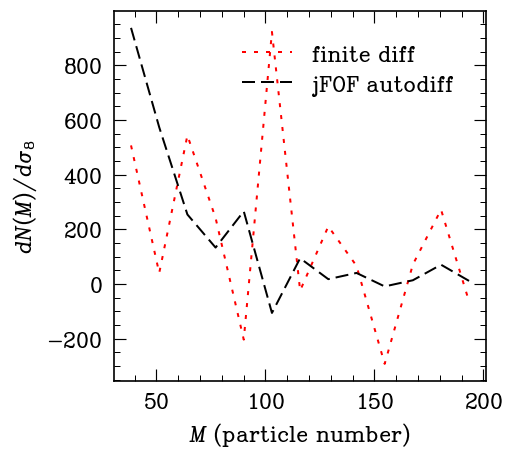

In [103]:
import smplotlib
plt.figure(figsize=(4,4))
plt.plot(bin_centers[2:],((h81-h80)/0.01)[2:],"r:",label="finite diff")
plt.plot(bin_centers[2:],grad80[2:],"k--",label="jFOF autodiff")
plt.legend()
plt.xlabel("$M$ (particle number)")
plt.ylabel("$dN(M)/d\sigma_8$")
plt.savefig("dHMF.pdf")
plt.show()

In [95]:
initial_conditions = linear_field(mesh_shape, box_size, pk_fn, seed=jax.random.PRNGKey(10))

#this doesn't seem to work? Not sure why... gotta pass IC some other way...
@jax.jit
def hmf_surrogate(sigma8,initial_conditions):
    k = jnp.logspace(-4, 1, 128)
    pk = jc.power.linear_matter_power(jc.Planck15(Omega_c=0.25, sigma8=sigma8), k)
    pk_fn = lambda x: jnp.abs(jc.scipy.interpolate.interp(x.reshape([-1]), k, pk).reshape(x.shape))

    particles = jnp.stack(jnp.meshgrid(*[jnp.arange(s) for s in mesh_shape]),axis=-1).reshape([-1,3])
    cosmo = jc.Planck15(Omega_c=0.25, sigma8=sigma8)
    dx, p, f = lpt(cosmo, initial_conditions, particles, a=0.1)

    res = odeint(make_ode_fn(mesh_shape), [particles + dx, p], snapshots, cosmo, rtol=1e-8, atol=1e-8)
    fl = fof_fn(res[0][-1])   # frozen topology capsule
    out = halo_mass_surrogate(fl, res[0][-1], mpart=1.0, alpha=100) #1000 seems to be too much

    return soft_histogram(out.masses_full,bin_centers,width)

In [89]:
jac = jax.jacobian(hmf_surrogate,argnums=0)

In [90]:
jac(0.8, initial_conditions=initial_conditions)

Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],      dtype=float32, weak_type=True)

In [ ]:
#very long loop, jacobians are very expensive to compute (but make pretty plots!)
jac_array = []
finite_array = []
for seed_num in range(0,20):
    print(seed_num)

    #seems poorly behaved when passing IC as a variable along with sigma8? Very hacky and takes a while to run, but just demo anyway...
    @jax.jit
    def hmf_surrogate(sigma8):
        k = jnp.logspace(-4, 1, 128)
        pk = jc.power.linear_matter_power(jc.Planck15(Omega_c=0.25, sigma8=sigma8), k)
        pk_fn = lambda x: jnp.abs(jc.scipy.interpolate.interp(x.reshape([-1]), k, pk).reshape(x.shape))
        initial_conditions = linear_field(mesh_shape, box_size, pk_fn, seed=jax.random.PRNGKey(seed_num))

        particles = jnp.stack(jnp.meshgrid(*[jnp.arange(s) for s in mesh_shape]),axis=-1).reshape([-1,3])
        cosmo = jc.Planck15(Omega_c=0.25, sigma8=sigma8)
        dx, p, f = lpt(cosmo, initial_conditions, particles, a=0.1)

        res = odeint(make_ode_fn(mesh_shape), [particles + dx, p], snapshots, cosmo, rtol=1e-8, atol=1e-8)
        fl = fof_fn(res[0][-1])   # frozen topology capsule
        out = halo_mass_surrogate(fl, res[0][-1], mpart=1.0, alpha=100) #1000 seems to be too much

        return soft_histogram(out.masses_full,bin_centers,width)
    
    h80 = hmf_surrogate(0.8)
    h81 = hmf_surrogate(0.81)
    jac = jax.jacobian(hmf_surrogate)
    grad80 = jac(0.8)
    jac_array.append(grad80)
    finite_array.append([h80,h81])
    plt.figure(figsize=(4,4))
    plt.plot(bin_centers[2:],((h81-h80)/0.01)[2:],"r:",label="finite diff")
    plt.plot(bin_centers[2:],grad80[2:],"k--",label="jFOF autodiff")
    plt.legend()
    plt.xlabel("$M$ (particle number)")
    plt.ylabel("$dN(M)/d\sigma_8$")
    plt.savefig(str(seed_num)+"_dHMF.pdf")
    plt.show()


0


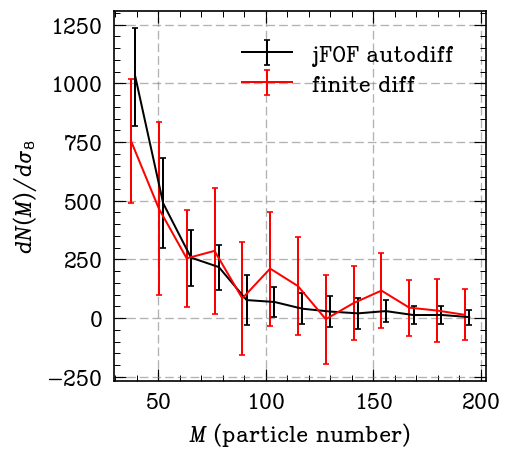

In [151]:
fd = [i[1]-i[0] for i in finite_array]
plt.figure(figsize=(4,4))

plt.errorbar(bin_centers[2:]+1,np.array(jac_array).mean(axis=0)[2:],yerr=np.array(jac_array).std(axis=0)[2:],color = "k",label="jFOF autodiff")
plt.errorbar(bin_centers[2:]-1,np.array(fd).mean(axis=0)[2:]/0.01,yerr=np.array(fd).std(axis=0)[2:]/0.01,color = "r",label="finite diff")
plt.legend()
plt.xlabel("$M$ (particle number)")
plt.ylabel("$dN(M)/d\sigma_8$")
plt.grid()

plt.savefig("dHMF.pdf")
plt.show()

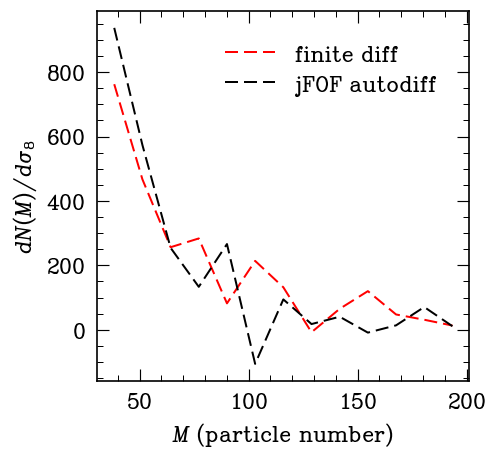

In [124]:
plt.figure(figsize=(4,4))
plt.plot(bin_centers[2:],np.array([i[1]-i[0] for i in finite_array]).mean(axis=0)[2:]/0.01,"r--",label="finite diff")
#plt.semilogy(grad80,"r:")
plt.plot(bin_centers[2:],grad80[2:],"k--",label="jFOF autodiff")
plt.legend()
plt.xlabel("$M$ (particle number)")
plt.ylabel("$dN(M)/d\sigma_8$")
plt.savefig("dHMF.pdf")
plt.show()

In [260]:
np.save("hmf_finite_diff",np.array(finite_array))

In [261]:
np.save("hmf_jac",np.array(jac_array))